# Учебный проект

Представим ситуацию: я работаю в приложении по доставке готовых продуктов. Ко мне пришел коллега с результатами двух тестов:
- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
  
Коллега пришел ко мне с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. 
Моя задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## План:
1. Выбираю метод, который предположительно подойдет в первом вопросе.
2. Проверяю, являются ли дисперсии внутри групп гомогенными.
4. Провожу тест на нормальность распределения.
5. Сравниваю средние в представленных группах.
6. Определяю, между какими группами есть статистически значимые различия.
7. Выбираю метод для второго теста.
8. Визуализирую распределение для контрольной и тестовой групп.
9. Выбираю формулу для модели, провожу тест.

## Описание данных
### 5_task_1:
- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период
### 5_task_2:
- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период


In [9]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# импорт csv и загрузка их в df

task_1 = pd.read_csv('/Users/ajsyluakataeva/Karpov/math/stat 5/[SW.BAND] 5_task_1.csv')
task_2 = pd.read_csv('/Users/ajsyluakataeva/Karpov/math/stat 5/[SW.BAND] 5_task_2.csv')

In [11]:
# посмотрим на df

task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


<Axes: xlabel='group', ylabel='events'>

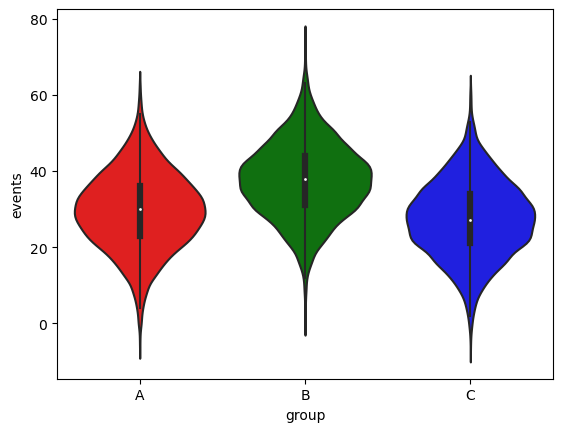

In [12]:
sns.violinplot(x="group", y="events", data=task_1, palette=["r", "g", "b"])

## 1. Разберемся для начала с картинками
Проведем дисперсионный анализ ANOVA

### Проверка групп на гомогенность 
выбираю:
- Тест Левена (Levene’s test)


In [13]:
#через pingouin 
pg.homoscedasticity(data=task_1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


### Проверка на нормальность распределения

In [14]:
#через pingouin
pg.normality(data=task_1, dv="events", group="group", method="normaltest")

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

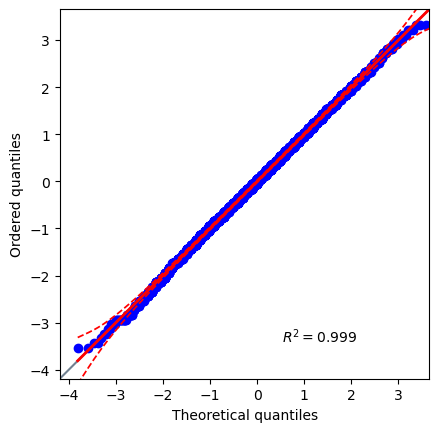

In [15]:
# q-q плот 
pg.qqplot(task_1.query("group == 'A'").events)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

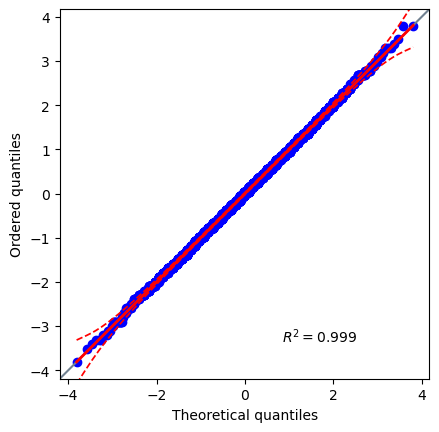

In [16]:
pg.qqplot(task_1.query("group == 'B'").events)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

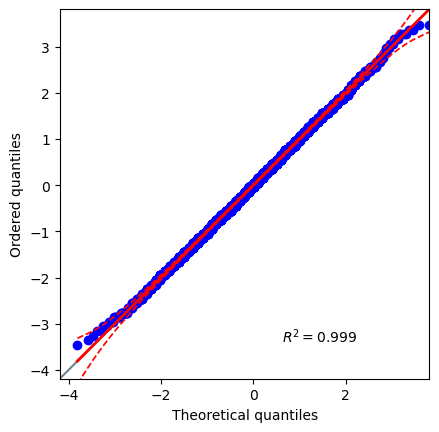

In [17]:
pg.qqplot(task_1.query("group == 'C'").events)

Группы прошли проверку на гомогенность и нормальность распределения

### Сравниваем средние в представленных группах.
Для сравнения средних логично использовать однофакторный дисперсионный анализ

In [37]:
#попарные сравнения без поправки
pg.anova(data=task_1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


### Использую критерий Тьюки для того, чтобы узнать между какими группами есть статистически важные различия

In [38]:
# statsmodels
MultiComparison(task_1.events, task_1.group).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.0,7.7038,8.3642,True
A,C,-2.1093,0.0,-2.4395,-1.7791,True
B,C,-10.1433,0.0,-10.4735,-9.8131,True


Text(0, 0.5, 'Число покупок')

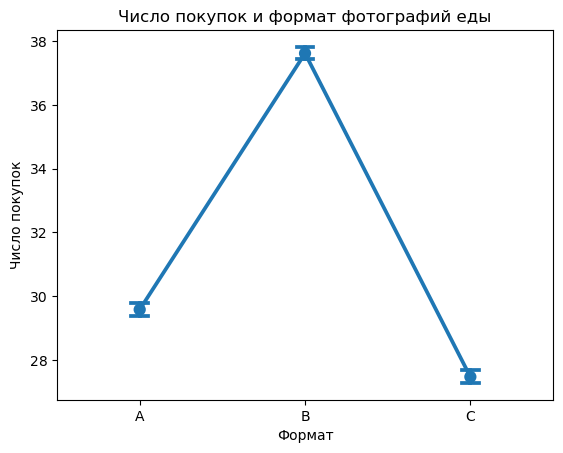

In [39]:
sns.pointplot(x='group', y = 'events', data = task_1, capsize=.1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')


In [40]:
pg.pairwise_tukey(data=task_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


Используем квадратные картинки, потому что B (квадратные картинки) статистически значимо отличается от А и С в большую сторону покупок

## 2. Группа 2

Требуется проверить как отреагируют пользователи на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиентов

In [41]:
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high


Для данного исследования использую многофакторный дисперсионный анализ

### Для начала посмотрим на данные 
Визуализируем распределение events для контрольной и тестовой группы

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='events', ylabel='Count'>

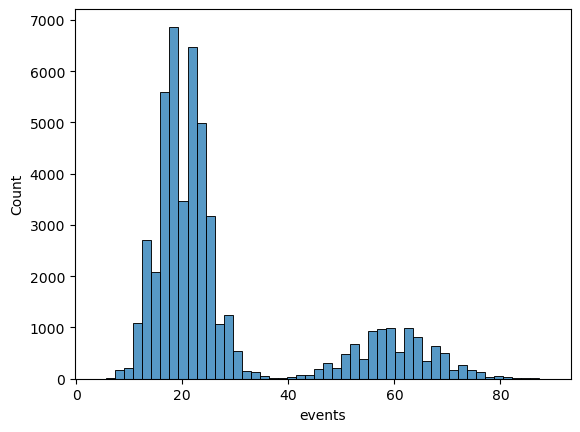

In [42]:
sns.histplot(x=task_2.query('group == "control"').events, bins=50)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='events', ylabel='Count'>

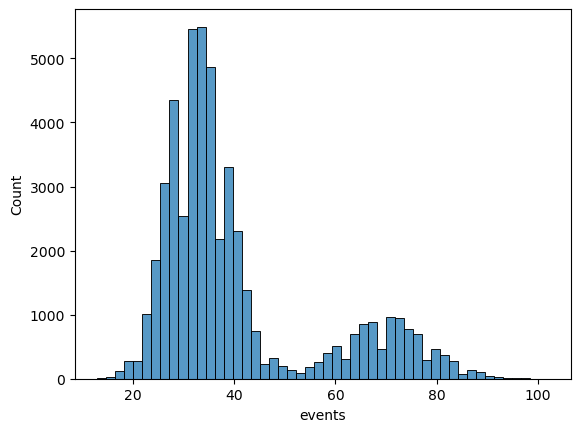

In [43]:
sns.histplot(x=task_2.query('group == "test"').events, bins=50)

<Axes: xlabel='group', ylabel='events'>

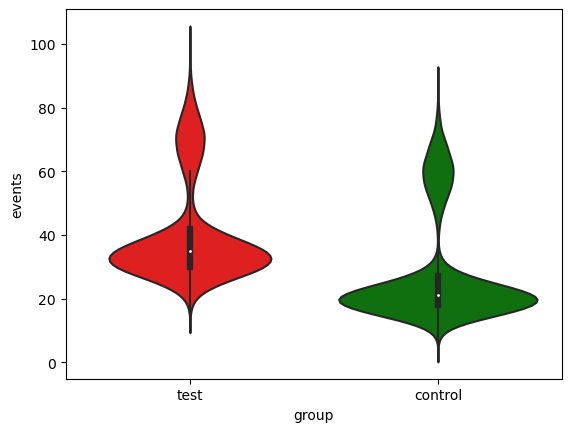

In [44]:
sns.violinplot(x="group", y="events", data=task_2, palette=["r", "g", "b"])

### Посмотрим на описательные статистики events в разбивке по группе и по сегменту пользователя.

In [45]:
task_2.groupby(['group', 'segment']).agg({'events':['mean', 'median', 'std']}).round(2).reset_index()

group segment events             
                     mean median   std
0  control    high  59.97   60.0  7.81
1  control     low  20.03   20.0  4.47
2     test    high  69.94   70.0  8.40
3     test     low  33.03   33.0  5.72

/var/folders/67/ddmy4vp54993p77g6knmjv780000gn/T/ipykernel_92230/2648900863.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(task_2.query('group == "test" and segment == "high"').events, label = 'test', kde=False)
/var/folders/67/ddmy4vp54993p77g6knmjv780000gn/T/ipykernel_92230/2648900863.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/

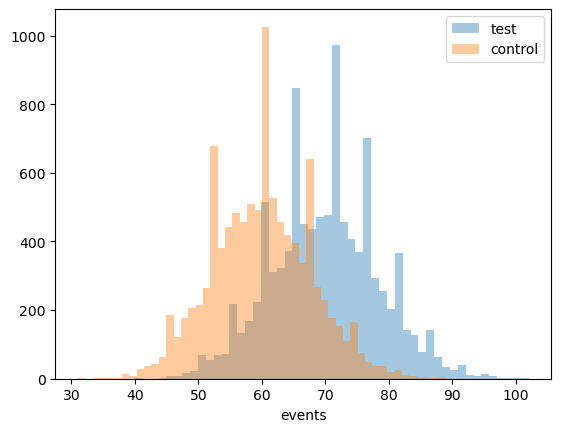

In [46]:
sns.distplot(task_2.query('group == "test" and segment == "high"').events, label = 'test', kde=False)
sns.distplot(task_2.query('group == "control" and segment == "high"').events, label = 'control', kde=False)
plt.legend()

/var/folders/67/ddmy4vp54993p77g6knmjv780000gn/T/ipykernel_92230/168456030.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(task_2.query('group == "test" and segment == "low"').events, label = 'test', kde=False)
/var/folders/67/ddmy4vp54993p77g6knmjv780000gn/T/ipykernel_92230/168456030.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

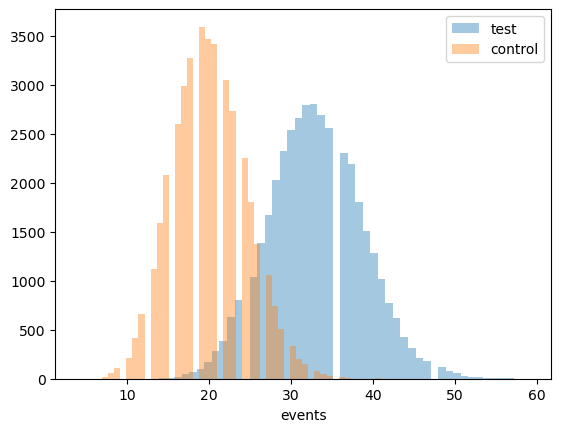

In [47]:
sns.distplot(task_2.query('group == "test" and segment == "low"').events, label = 'test', kde=False)
sns.distplot(task_2.query('group == "control" and segment == "low"').events, label = 'control', kde=False)
plt.legend()

### Проведем тест, проверим эффект нескольких переменных: group и segment на количество покупок events, а также эффект взаимодействия этих факторов 

In [48]:
#statsmodels

model = smf.ols(formula='events~segment+group+segment:group', data = task_2).fit()
aov_tabel = anova_lm(model)

In [49]:
aov_tabel 

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377481,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [50]:
pg.anova(data=task_2, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377485,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


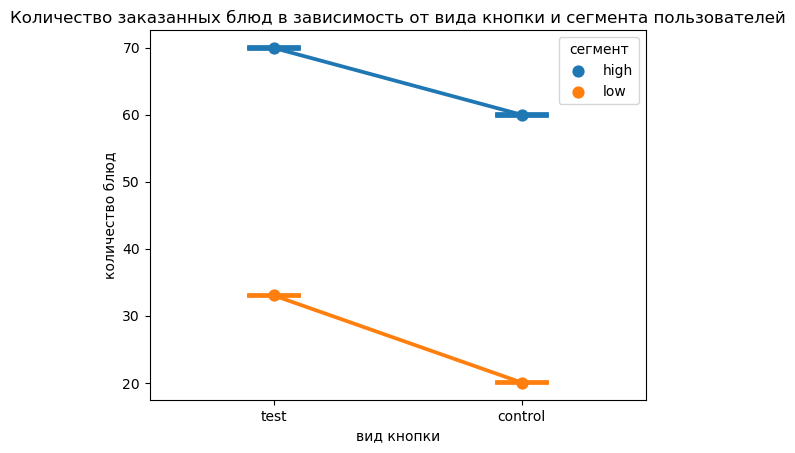

In [51]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = task_2, capsize = .2)
plt.title('Количество заказанных блюд в зависимость от вида кнопки и сегмента пользователей')
plt.xlabel('вид кнопки')
plt.ylabel('количество блюд')
plt.legend(title = 'сегмент')

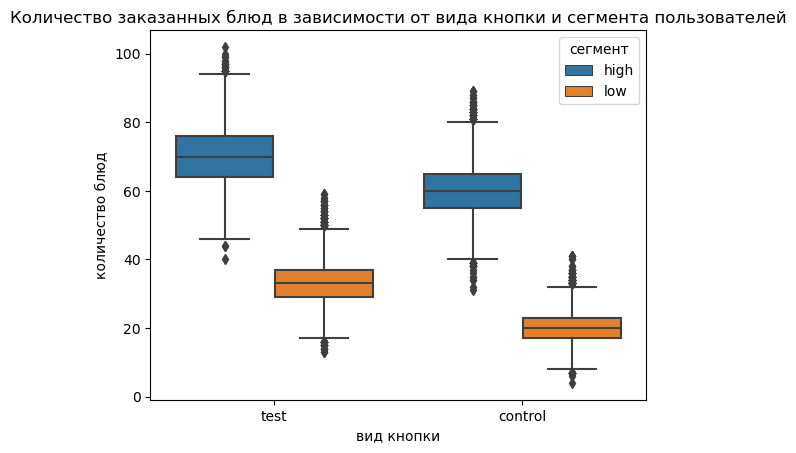

In [55]:
sns.boxplot(x = 'group', y = 'events', hue = 'segment', data = task_2)
plt.title('Количество заказанных блюд в зависимости от вида кнопки и сегмента пользователей')
plt.xlabel('вид кнопки')
plt.ylabel('количество блюд')
plt.legend(title = 'сегмент')

In [56]:
task_2['combination'] = task_2.group + '\\' + task_2.segment

In [57]:
task_2['combination']

0          test\high
1          test\high
2          test\high
3          test\high
4          test\high
            ...     
99995    control\low
99996    control\low
99997    control\low
99998    control\low
99999    control\low
Name: combination, Length: 100000, dtype: object

In [58]:
pg.pairwise_tukey(data=task_2, dv="events", between="combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,7.521612
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.228989
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.350026
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-9.091140
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.530414
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,5.814008


Все факторы (group, segment) оказались значимы (p-unc<0,05) и их взаимодействие тоже значимо. Среднее для всех групп увеличилось

##  Итоги и рекомендации

**A/B тест 1: Формат фотографий блюд**

- В тесте участвовали три группы: прямоугольные изображения (A и C) и квадратные изображения (B).
- Анализ показал, что группы проходят проверку на нормальность и гомогенность дисперсий.
- ANOVA и критерий Тьюки подтвердили, что **группа B** (квадратные изображения) **значимо превосходит** другие по количеству заказов.
- **Рекомендация**: масштабировать квадратные изображения на всех пользователей.

---

**A/B тест 2: Новый формат кнопки заказа**

- Проведен многофакторный дисперсионный анализ с учётом сегментов `high` и `low`.
- Пользователи из **high-сегмента** показали **рост активности** в тестовой группе по сравнению с контрольной.
- **Рекомендация**: раскатить новую кнопку сначала на high-сегмент, протестировать повторно с фокусом на поведенческие метрики (например, CR в заказ).

---

Оба теста прошли корректный статистический анализ. Предложенные изменения основаны на значимых различиях и могут положительно повлиять на бизнес-показатели.